<a href="https://colab.research.google.com/github/brit228/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-4-select-important-features/LS_DS_244_Feature_Selection_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import
import numpy as np

# Create the dataset
# from https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

np.random.seed(42)

size = 1500 # I increased the size from what's given in the link
Xs = np.random.uniform(0, 1, (size, 14)) 
# Changed variable name to Xs to use X later
 
#"Friedamn #1” regression problem
Y = (10 * np.sin(np.pi*Xs[:,0]*Xs[:,1]) + 20*(Xs[:,2] - .5)**2 +
     10*Xs[:,3] + 5*Xs[:,4] + np.random.normal(0,1))
#Add 4 additional correlated variables (correlated with X1-X4)
Xs[:,10:] = Xs[:,:4] + np.random.normal(0, .025, (size,4))
 
names = ["X%s" % i for i in range(1,15)]

In [2]:
# Putting it into pandas--because... I like pandas. And usually you'll be
# working with dataframes not arrays (you'll care what the column titles are)
import pandas as pd

friedmanX = pd.DataFrame(data=Xs, columns=names)
friedmanY = pd.Series(data=Y, name='Y')

friedman = friedmanX.join(friedmanY)

friedman.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,Y
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,0.413325,0.956360,0.698205,0.568729,16.730915
1,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229,0.611853,0.139494,0.292145,0.366362,0.223650,0.167876,0.280668,0.561691,9.112092
2,0.592415,0.046450,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.617692,0.078302,0.583794,0.132396,3.017894
3,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854,0.969585,0.775133,0.037718,0.917699,0.267895,0.699477,10.220976
4,0.088493,0.195983,0.045227,0.325330,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.045148,0.217475,0.017812,0.346724,9.770285


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
  """Uniformly spaced Gaussian features for one-dimensional input"""

  def __init__(self, N, width_factor=2.0):
    self.N = N
    self.width_factor = width_factor

  @staticmethod
  def _gauss_basis(x, y, width, axis=None):
    arg = (x - y) / width
    return np.exp(-0.5 * np.sum(arg ** 2, axis))

  def fit(self, X, y=None):
    # create N centers spread along the data range
    self.centers_ = np.zeros((self.N, X.shape[1]))
    self.width_ = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
      self.centers_[:,i] = np.linspace(X[:,i].min(), X[:,i].max(), self.N)
      self.width_[i] = self.width_factor * (self.centers_[1,i] - self.centers_[0,i])
    return self

  def transform(self, X):
    out = np.zeros((X.shape[0], self.N * X.shape[1]))
    for i in range(X.shape[1]):
      out[:,i] = self._gauss_basis(X[:, i, np.newaxis], self.centers_[:,i], self.width_[i], axis=1)
    return out

In [92]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFdr, f_regression, RFECV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

n = 2
m = 1
params = {"feature_add__poly__degree": list(range(2,5+1,1)),
         "feature_add__gauss__N": list(range(2,6+1,1)),
         "model__alpha": [np.power(10.0, i/n) for i in range(-4*n,1*n+1,m)]}

gauss_model = GridSearchCV(Pipeline([("scaler", StandardScaler()),
                                     ("feature_add", FeatureUnion([("poly", PolynomialFeatures()), ("gauss", GaussianFeatures(N=3))])),
                                     ("model", Ridge())]), 
                            params, cv=5, verbose=10)

X_train, X_test, y_train, y_test = train_test_split(friedman.drop(columns=['Y'], axis=1), friedman['Y'], test_size=0.1, random_state=42)
gauss_model.fit(X_train, y_train)

print(mean_absolute_error(y_pred, y_test), r2_score(y_pred, y_test))
print(gauss_model.best_params_)

pipe = gauss_model.best_estimator_

features = pipe.named_steps["feature_add"].transformer_list[0][1].get_feature_names([c for c in X_train])
features += ["{}_g{}".format(features[x+1],i) for x in range(X_train.shape[1]) for i in range(pipe.named_steps["feature_add"].transformer_list[1][1].N)]
print(features)

def transform(pipe, X):
  x = X.copy()
  for i in pipe.steps:
    if i[0] != "model":
      x = i[1].transform(x)
  return x

pipe = gauss_model.best_estimator_

gauss_model2 = RFECV(gauss_model.best_estimator_.named_steps["model"], verbose=1)
gauss_model2.fit(transform(pipe, X_train), y_train)

y_pred = gauss_model2.predict(transform(pipe, X_test))
print(mean_absolute_error(y_pred, y_test), r2_score(y_pred, y_test))
print([x for i,x in enumerate(features) if gauss_model2.get_support()[i]])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001, score=0.9885113643034165, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001, score=0.9908025918440182, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001, score=0.9882217077193574, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001, score=0.9882347586647708, total=   0.2s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.001, score=0.9888994734153685, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794, score=0.9894490919284334, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794, score=0.9915839512186737, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794, score=0.9890384914957666, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794, score=0.9894059756235698, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s


[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.0031622776601683794, score=0.9896565642545376, total=   0.2s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01, score=0.9900251822723536, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01, score=0.9921397779841714, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01, score=0.989758210490895, total=   0.2s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01 
[CV]  feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01, score=0.9900396068636949, total=   0.1s
[CV] feature_add__gauss__N=3, feature_add__poly__degree=3, model__alpha=0.01 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   20.3s finished


Fitting estimator with 735 features.
Fitting estimator with 734 features.
Fitting estimator with 733 features.
Fitting estimator with 732 features.
Fitting estimator with 731 features.
Fitting estimator with 730 features.
Fitting estimator with 729 features.
Fitting estimator with 728 features.
Fitting estimator with 727 features.
Fitting estimator with 726 features.
Fitting estimator with 725 features.
Fitting estimator with 724 features.
Fitting estimator with 723 features.
Fitting estimator with 722 features.
Fitting estimator with 721 features.
Fitting estimator with 720 features.
Fitting estimator with 719 features.
Fitting estimator with 718 features.
Fitting estimator with 717 features.
Fitting estimator with 716 features.
Fitting estimator with 715 features.
Fitting estimator with 714 features.
Fitting estimator with 713 features.
Fitting estimator with 712 features.
Fitting estimator with 711 features.
Fitting estimator with 710 features.
Fitting estimator with 709 features.
F

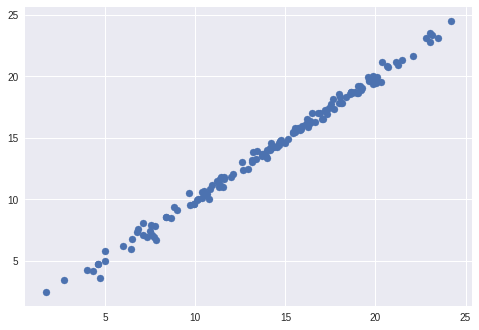

In [93]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test)

In [103]:
import pandas as pd

print(pd.DataFrame(np.array([gauss_model2.estimator_.coef_, np.abs(gauss_model2.estimator_.coef_)]).T, columns=["Coefficients", "abs(Coefficients)"], index=[x for i,x in enumerate(features) if gauss_model2.get_support()[i]]).sort_values(by="abs(Coefficients)", ascending=False))

             Coefficients  abs(Coefficients)
X1 X11 X13      -5.589657           5.589657
X4_g0           -4.266886           4.266886
X11^2 X13        3.776942           3.776942
X4 X10 X12      -3.242130           3.242130
X10 X12 X14      3.203603           3.203603
X1 X2 X13       -3.014980           3.014980
X2 X4 X10        2.977785           2.977785
X1               2.968126           2.968126
X2               2.939305           2.939305
X2 X10 X14      -2.938916           2.938916
X2 X11 X13       2.916099           2.916099
X4               2.870548           2.870548
X3 X10 X13       2.798323           2.798323
X1_g1            2.618950           2.618950
X8 X11 X14      -2.535693           2.535693
X4 X8 X11        2.511331           2.511331
X1 X8 X14        2.438402           2.438402
X1 X4 X8        -2.438111           2.438111
X3^2             2.089719           2.089719
X1 X3 X12        1.920627           1.920627
X3 X11 X12      -1.807068           1.807068
X1 X9 X11 